# Final Project - Predicting Song Popularity on Spotify
### Kaitlin Cochran

For my final project, I wish to explore if variables created by Spotify for a track (i.e. danceability, key, etc.) have an impact on how popular the track is. I was motivated by my want to use the Spotify API for something. Music has been a part of my life since I can remember and has held a special place in my heart when dealing with both happy and sad events in my life. I came up with the idea to try and predict what songs will be popular next because I often discover "popular" songs either before they become popular or after they have already been popular. 

I honestly had no idea that anyone else had thought of doing this before me, but Dr. Silva showed me there are many popular models that use Spotify API analysis data to predict popular songs, some with a very high rate of success. I hope to find some correlations in my data, but I don't expect to be as accurate as those models.

To attempt to do this, I decided to use Spotify, which is a music streaming platform. I used the "Top Songs USA" and "New Music Friday" playlists, as well as some songs from my own playlists to compare and see if I could predict their popularity. I would say these playlists have songs in them that are popular according to the data Spotify collects, specifically in the United States. I don't believe the playlist would be the same if it was analyzing top songs in another country. Some songs may still appear in both, but not all and perhaps not in the same order. I also will need to pick a song to compare to this data that is relatively new, to see if my predictions are right.

I would say I trust this data, because Spotify has been around for a long time and they have a certain way to calculate the values I am using from the Audio Features endpoint. The endpoints I am using are also used in other analyses, so that adds another layer of trustworthiness to the data since other people are analysing the same thing and trying to draw similar conclusions.

# The API Queries

Import statements for the libraries I will be using.

In [20]:
import pandas as pd
import requests
import base64
import json
from matplotlib import pyplot as plt

Reading in my tokens and formatting them for a new application on the Spotify developer website.

In [21]:
tokens = pd.read_csv('keys.txt', sep = '\t', header = None).T
tokens.columns = tokens.iloc[0]
tokens = tokens[1:]

A function we made together in class which creates a session header to use to connect to the client.

In [22]:
def start_session_headers(client_id, client_secret):
    client_cred = base64.b64encode(str(client_id + ":" + client_secret).encode('ascii'))
    header = {'Authorization': 'Basic %s' % (client_cred.decode('ascii'))}
    return header

A function we made together in class which connects to the client using the URL and header.

In [23]:
def connect_to_client_cred(url, header):
        payload = {'grant_type' : 'client_credentials'}
        response = requests.request("POST", url, headers = header, data = payload )
        print(response.status_code)
        if response.status_code != 200:
            raise Exception(response.status_code, response.text)
        return response.json()

A function we made together in class which gets an access token using both of the above methods in order to query specific Spotify APIs.

In [24]:
def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    header = start_session_headers(client_id, client_secret)
    json_response = connect_to_client_cred(url, header)
    return json_response

Acquiring the session token.

In [25]:
session_token = get_access_token(tokens['clientID'].iloc[0], tokens['clientSecret'].iloc[0])

200


A function we made in class that creates a header to query Spotify APIs.

In [26]:
def create_header(session_token):
    headers = {"Authorization": "Bearer {}".format(session_token)}
    return headers

A function we made in class that connects to a specific Spotify endpoint to gather specific data through a GET request.

In [27]:
def connect_to_endpoint(url, headers):
    response = requests.request("GET", url, headers = headers)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

A function I created to gather information about a Spotify playlist through the playlist id, found on Spotify.

In [28]:
def get_a_playlist(playlist_id):
    url = 'https://api.spotify.com/v1/playlists/{}/tracks'.format(playlist_id)
    header = create_header(session_token['access_token'])
    json_response = connect_to_endpoint(url, header)
    return json_response

A function we created in class to get information about a track on Spotify through the track id, found on Spotify.

In [29]:
def get_a_track(track_id):
    url = 'https://api.spotify.com/v1/tracks/{}'.format(track_id)
    header = create_header(session_token['access_token'])
    json_response = connect_to_endpoint(url, header)
    return json_response

A function we created in class to get Spotify-created variables about tracks through the track id, found on Spotify.

In [30]:
def track_audio_features(track_id, offset):
    url = 'https://api.spotify.com/v1/audio-features/{}?offset={}'.format((track_id), format(offset))
    header = create_header(session_token['access_token'])
    json_response = connect_to_endpoint(url, header)
    return json_response

Querying the Playlist API using the playlist id for the Top Songs USA playlist and finding keys for later list comprehension.

In [31]:
playlist = get_a_playlist('37i9dQZEVXbLp5XoPON0wI')
playlist.keys()
playlist['items'][0]['track']['id']
playlist['items'][0]['track']['name']

200


'Easy On Me'

Using list comprehension to get all tracks, track names, and track popularity values from the playlist.

In [32]:
tracks = [x['track']['id'] for x in playlist['items']]
trackNames = [x['track']['name'] for x in playlist['items']]
trackPopularity = [x['track']['popularity'] for x in playlist['items']]

Getting audio feature information for all songs in the Top Songs USA playlist.

In [ ]:
trackInfo = [track_audio_features(x, 50) for x in tracks]

Running through the same code used for the Top Songs USA playlist, but for the New Music Friday playlist.

In [ ]:
newTracksPlaylist = get_a_playlist('37i9dQZF1DX4JAvHpjipBk')
newTracks = [x['track']['id'] for x in newTracksPlaylist['items']]
newTrackNames = [x['track']['name'] for x in newTracksPlaylist['items']]
newTrackInfo = [track_audio_features(x, 50) for x in newTracks]
newTrackPopularity = [x['track']['popularity'] for x in newTracksPlaylist['items']]
tracks2 = [x for ind, x in enumerate(newTracks) if 49 > ind > 0]
newTrackInfo2 = [track_audio_features(x, 100) for x in tracks2]

# The DataFrames

The structure of the data varies depending on which endpoint one uses. All endpoints that I have used return JSON objects, which is a block of text similar to a list in Python. They have arrays, and those arrays have arrays, and so on, to include different types of information such as countries the song is available in, the artist, track name, track length, and almost any other imaginable piece of information about a song. When I first queried these APIs in class, I was blown away by how much data there was on just one track in the billions that Spotify offers. 

I will be using several pieces from the Track API, such as the name of the track and the track URI, which is the main identifier for a track, to merge DataFrames together to make the most sensible DataFrame to use for my analysis. I will use the track URI to query the Track Audio Features API, which contains information calculated by Spotify, such as danceability, tempo, key, and others. 

Creating a Data Frame from the response from the Audio Features API.

In [34]:
tracksDf = pd.DataFrame(trackInfo)

Creating a Data Frame using the track ids and names obtained earlier.

In [35]:
trackNamesDf = pd.DataFrame({'id': tracks, 'name': trackNames, 'popularity': trackPopularity})

Creating and formatting the final data frame for this playlist, which combines the above Data Frame of ids and names with the original Data Frame containing audio track information.

In [36]:
finalDf = pd.merge(tracksDf, trackNamesDf, left_on = "id", right_on = 'id', how = 'left')
finalDf.drop(['type', 'uri', 'track_href', 'analysis_url' ], axis = 1).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,popularity
0,0.604,0.366,5,-7.519,1,0.0282,0.5780,0.000000,0.1330,0.130,141.981,46IZ0fSY2mpAiktS3KOqds,224695,4,Easy On Me,91
1,0.631,0.518,0,-8.771,1,0.0303,0.2740,0.000000,0.0880,0.205,93.023,5enxwA8aAbwZbf5qCHORXi,613027,4,All Too Well (10 Minute Version) (Taylor's Ver...,96
2,0.741,0.691,10,-7.395,0,0.0672,0.0221,0.000000,0.0476,0.892,150.087,5Z9KJZvQzH6PFmb8SNkxuk,212353,4,INDUSTRY BABY (feat. Jack Harlow),91
3,0.591,0.764,1,-5.484,1,0.0483,0.0383,0.000000,0.1030,0.478,169.928,5PjdY0CKGZdEuoNab3yDmX,141806,4,STAY (with Justin Bieber),92
4,0.761,0.525,11,-6.900,1,0.0944,0.4400,0.000007,0.0921,0.531,80.870,02MWAaffLxlfxAUY7c5dvx,238805,4,Heat Waves,92


Creating a dataframe to combine all of the audio features for all the tracks together, and then adding the names of the tracks according to id value like done above.

In [38]:
newTracksDf = pd.DataFrame(newTrackInfo)
newTracksDf2 = pd.DataFrame(newTrackInfo2)
newTrackNamesDf = pd.DataFrame({'id': newTracks, 'name': newTrackNames, 'popularity': newTrackPopularity})

Creating a new dataframe from the track information of the New Music Friday playlist.

In [39]:
frames = [newTracksDf, newTracksDf2]
newFinalDf = pd.concat(frames)

Creating and formatting the final data frame for the New Music Friday playlist.

In [40]:
trackNamesWithData = pd.merge(newFinalDf, newTrackNamesDf, left_on = "id", right_on = 'id', how = 'left')
trackNamesWithData.drop(['type', 'uri', 'track_href', 'analysis_url' ], axis = 1).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,popularity
0,0.687,0.645,0,-4.761,1,0.040,0.0509,0.000003,0.1060,0.4240,135.083,5J6rTmMjF9DVIAF8G3M9n4,189728,4,Wandered To LA (with Justin Bieber),83
1,0.566,0.581,9,-5.181,1,0.043,0.2160,0.000000,0.0853,0.1520,130.043,3QPBocWfIcOCdFFvmqn60F,201668,4,Just Look Up (From Don’t Look Up),78
2,0.465,0.729,3,-6.930,0,0.237,0.0072,0.000000,0.1390,0.6060,95.001,4dZTNKRngStyYNueXCO2FR,172394,5,Young N Dumb,75
3,0.547,0.619,3,-6.485,0,0.132,0.0951,0.000003,0.0716,0.5190,76.285,0tkgmjBMU6qSxolAKB3f2H,233070,4,MERCEDES,73
4,0.398,0.286,7,-11.881,1,0.033,0.6160,0.000146,0.0912,0.0666,78.262,2KnLkZ3z7PO3kgVGHGqDpD,222800,4,It'll Be Okay,82


# The Analysis

The Audio Features API from Spotify has many variables that can have different values across different tracks. For ease of understanding I have listed the ones I will be using in my analysis and their definitions below. I realize some of these are a bit dense, but I think the entire definition straight from the Get Track and Get Audio Features documentation will help with the understanding of my analysis.

#### Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

#### Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

#### Key
The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

#### Loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.

#### Speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

#### Acousticness
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

#### Instrumentalness
Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

#### Liveness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

#### Valence
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

#### Tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration

#### Duration_ms
The duration of the track in milliseconds.

#### Time_signature
An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

#### Popularity
The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.

## Visual Representations

I started with graphing the values against each other to see if there were a lot of songs who had similar values, and it appears that there was a trend of songs having a certain value for some variables.

In the graphs below, the purple color is values from the New Music Friday playlist, while the orange color is values from the Top Songs USA playlist. There appear to be some trends, but I will need more statistical analysis to come up with a way to figure out if the values with more songs mean anything significant or not.

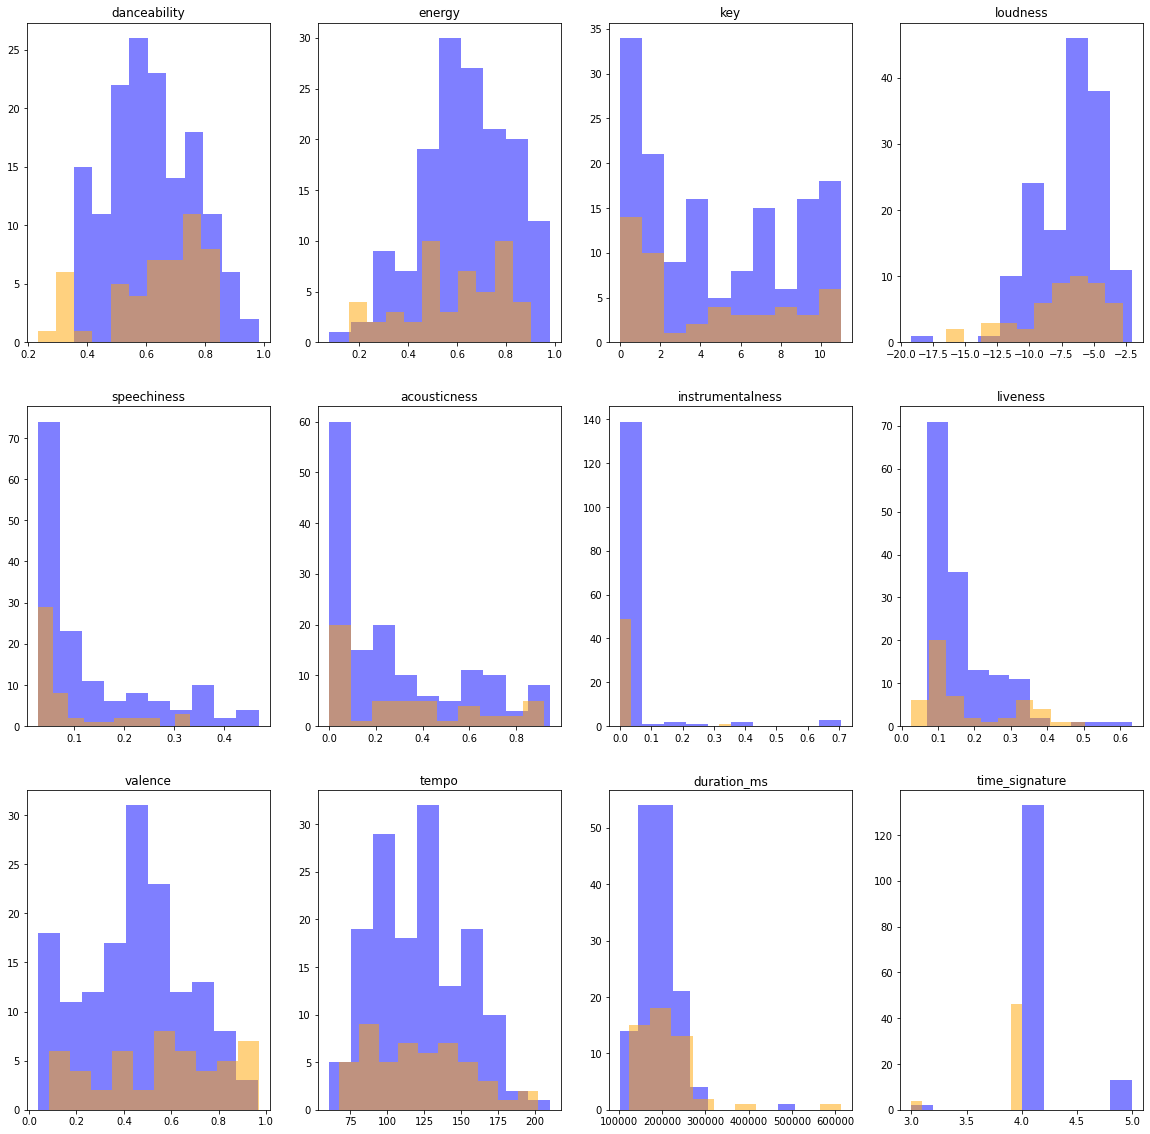

In [55]:
fig1, ax1 = plt.subplots(3, 4, figsize = (20, 20))
ax1[0, 0].title.set_text("danceability")
ax1[0, 0].hist(trackNamesWithData['danceability'], color = "blue", alpha = .5)
ax1[0, 0].hist(finalDf['danceability'], color = "orange", alpha = .5)

ax1[0, 1].title.set_text("energy")
ax1[0, 1].hist(trackNamesWithData['energy'], color = "blue", alpha = .5)
ax1[0, 1].hist(finalDf['energy'], color = "orange", alpha = .5)

ax1[0, 2].title.set_text("key")
ax1[0, 2].hist(trackNamesWithData['key'], color = "blue", alpha = .5)
ax1[0, 2].hist(finalDf['key'], color = "orange", alpha = .5)

ax1[0, 3].title.set_text("loudness")
ax1[0, 3].hist(trackNamesWithData['loudness'], color = "blue", alpha = .5)
ax1[0, 3].hist(finalDf['loudness'], color = "orange", alpha = .5)

ax1[1, 0].title.set_text("speechiness")
ax1[1, 0].hist(trackNamesWithData['speechiness'], color = "blue", alpha = .5)
ax1[1, 0].hist(finalDf['speechiness'], color = "orange", alpha = .5)

ax1[1, 1].title.set_text("acousticness")
ax1[1, 1].hist(trackNamesWithData['acousticness'], color = "blue", alpha = .5)
ax1[1, 1].hist(finalDf['acousticness'], color = "orange", alpha = .5)

ax1[1, 2].title.set_text("instrumentalness")
ax1[1, 2].hist(trackNamesWithData['instrumentalness'], color = "blue", alpha = .5)
ax1[1, 2].hist(finalDf['instrumentalness'], color = "orange", alpha = .5)

ax1[1, 3].title.set_text("liveness")
ax1[1, 3].hist(trackNamesWithData['liveness'], color = "blue", alpha = .5)
ax1[1, 3].hist(finalDf['liveness'], color = "orange", alpha = .5)

ax1[2, 0].title.set_text("valence")
ax1[2, 0].hist(trackNamesWithData['valence'], color = "blue", alpha = .5)
ax1[2, 0].hist(finalDf['valence'], color = "orange", alpha = .5)

ax1[2, 1].title.set_text("tempo")
ax1[2, 1].hist(trackNamesWithData['tempo'], color = "blue", alpha = .5)
ax1[2, 1].hist(finalDf['tempo'], color = "orange", alpha = .5)

ax1[2, 2].title.set_text("duration_ms")
ax1[2, 2].hist(trackNamesWithData['duration_ms'], color = "blue", alpha = .5)
ax1[2, 2].hist(finalDf['duration_ms'], color = "orange", alpha = .5)

ax1[2, 3].title.set_text("time_signature")
ax1[2, 3].hist(trackNamesWithData['time_signature'], color = "blue", alpha = .5)
ax1[2, 3].hist(finalDf['time_signature'], color = "orange", alpha = .5)



plt.show()

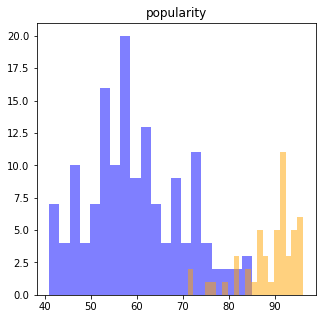

In [56]:
fig2, ax2 = plt.subplots(1, 1, figsize = (5, 5))
ax2.title.set_text("popularity")
ax2.hist(trackNamesWithData['popularity'], color = "blue", alpha = .5, bins = 20)
ax2.hist(finalDf['popularity'], color = "orange", alpha = .5, bins = 20)

plt.show()

Based on the bar graphs above, and the fact that there are more songs in the New Music Friday playlist than there are on the Top Songs USA playlist, I will also recreate these graphs as scatter plots to see where individual songs lie.

In [43]:
import numpy as np
aOffset = np.random.randn(len(trackNamesWithData.index)) * .02
bOffset = np.random.randn(len(finalDf.index)) * .02
aX = [0] * len(trackNamesWithData.index)
bX = [1] * len(finalDf.index)
aJitter = aX + aOffset
bJitter = bX + bOffset

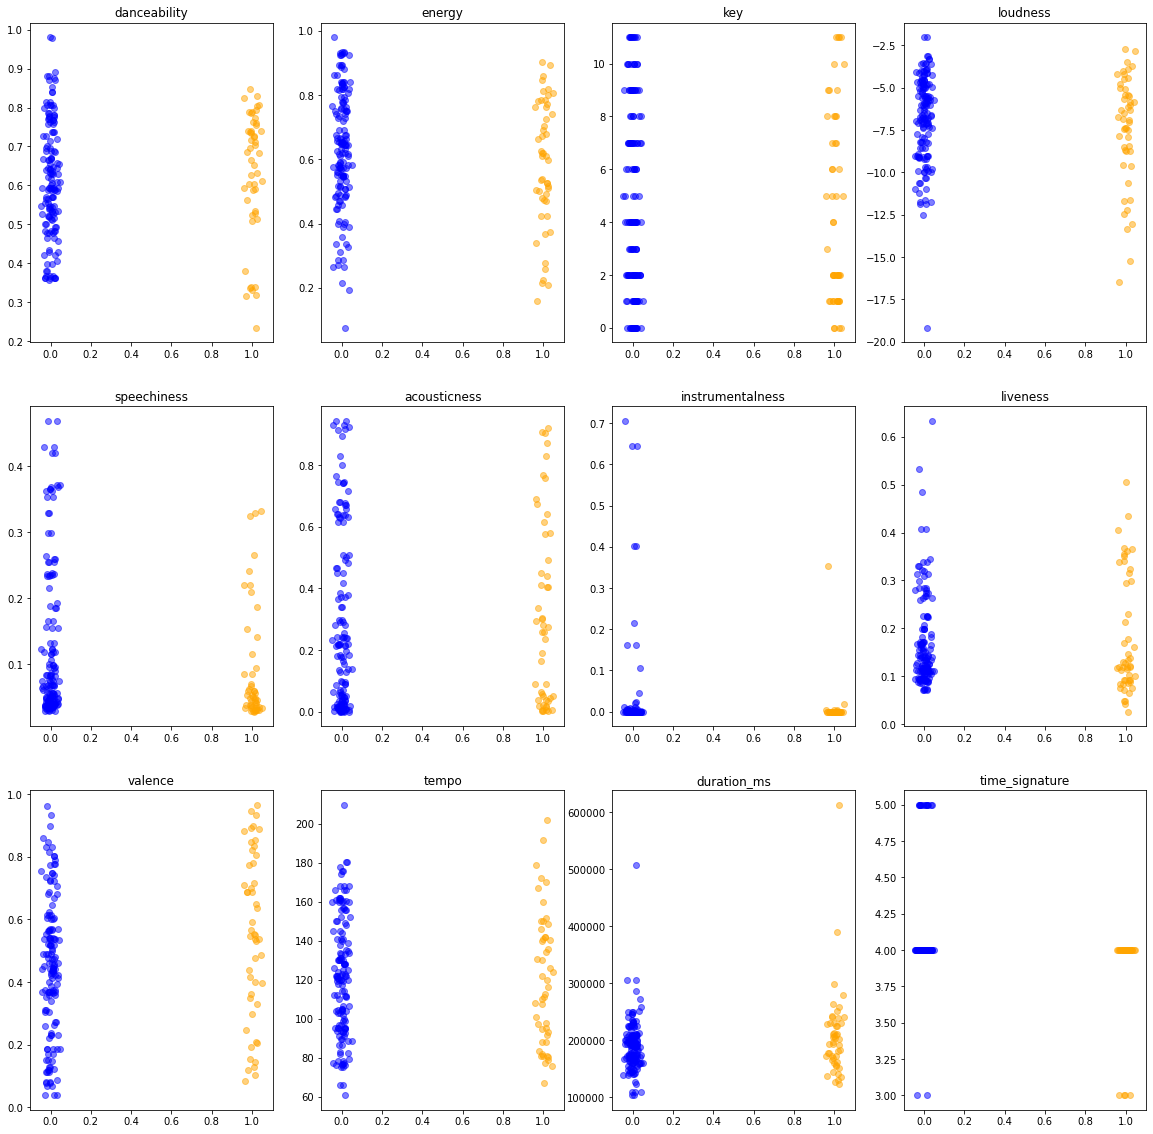

In [57]:
fig3, ax3 = plt.subplots(3, 4, figsize = (20, 20))
                         
ax3[0, 0].title.set_text("danceability")
ax3[0, 0].scatter(y = trackNamesWithData['danceability'], x = aJitter, color = 'blue', alpha = .5)
ax3[0, 0].scatter(y = finalDf['danceability'], x = bJitter, color = 'orange', alpha = .5)
                         
ax3[0, 1].title.set_text("energy")
ax3[0, 1].scatter(y = trackNamesWithData['energy'], x = aJitter, color = 'blue', alpha = .5)
ax3[0, 1].scatter(y = finalDf['energy'], x = bJitter, color = 'orange', alpha = .5)
                        
ax3[0, 2].title.set_text("key")
ax3[0, 2].scatter(y = trackNamesWithData['key'], x = aJitter, color = 'blue', alpha = .5)
ax3[0, 2].scatter(y = finalDf['key'], x = bJitter, color = 'orange', alpha = .5)                        
                         
ax3[0, 3].title.set_text("loudness")
ax3[0, 3].scatter(y = trackNamesWithData['loudness'], x = aJitter, color = 'blue', alpha = .5)
ax3[0, 3].scatter(y = finalDf['loudness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax3[1, 0].title.set_text("speechiness")
ax3[1, 0].scatter(y = trackNamesWithData['speechiness'], x = aJitter, color = 'blue', alpha = .5)
ax3[1, 0].scatter(y = finalDf['speechiness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax3[1, 1].title.set_text("acousticness")
ax3[1, 1].scatter(y = trackNamesWithData['acousticness'], x = aJitter, color = 'blue', alpha = .5)
ax3[1, 1].scatter(y = finalDf['acousticness'], x = bJitter, color = 'orange', alpha = .5)
                         
ax3[1, 2].title.set_text("instrumentalness")
ax3[1, 2].scatter(y = trackNamesWithData['instrumentalness'], x = aJitter, color = 'blue', alpha = .5)
ax3[1, 2].scatter(y = finalDf['instrumentalness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax3[1, 3].title.set_text("liveness")
ax3[1, 3].scatter(y = trackNamesWithData['liveness'], x = aJitter, color = 'blue', alpha = .5)
ax3[1, 3].scatter(y = finalDf['liveness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax3[2, 0].title.set_text("valence")
ax3[2, 0].scatter(y = trackNamesWithData['valence'], x = aJitter, color = 'blue', alpha = .5)
ax3[2, 0].scatter(y = finalDf['valence'], x = bJitter, color = 'orange', alpha = .5)
                         
ax3[2, 1].title.set_text("tempo")
ax3[2, 1].scatter(y = trackNamesWithData['tempo'], x = aJitter, color = 'blue', alpha = .5)
ax3[2, 1].scatter(y = finalDf['tempo'], x = bJitter, color = 'orange', alpha = .5)           

ax3[2, 2].title.set_text("duration_ms")
ax3[2, 2].scatter(y = trackNamesWithData['duration_ms'], x = aJitter, color = 'blue', alpha = .5)
ax3[2, 2].scatter(y = finalDf['duration_ms'], x = bJitter, color = 'orange', alpha = .5)  

ax3[2, 3].title.set_text("time_signature")
ax3[2, 3].scatter(y = trackNamesWithData['time_signature'], x = aJitter, color = 'blue', alpha = .5)
ax3[2, 3].scatter(y = finalDf['time_signature'], x = bJitter, color = 'orange', alpha = .5)   
                         
plt.show()

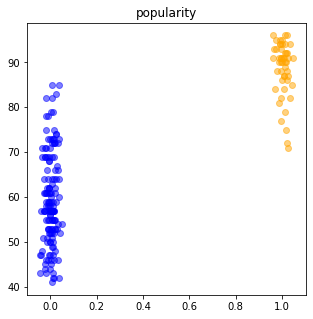

In [58]:
fig4, ax4 = plt.subplots(1, 1, figsize = (5, 5))
                         
ax4.title.set_text("popularity")
ax4.scatter(y = trackNamesWithData['popularity'], x = aJitter, color = 'blue', alpha = .5)
ax4.scatter(y = finalDf['popularity'], x = bJitter, color = 'orange', alpha = .5)

Immediately, the graphs that stood out to me were key, loudness, speechiness, instrumentalness, liveness, and time_signature. This is beacause the two data sets show a large amount of difference in all of these specific variables. 

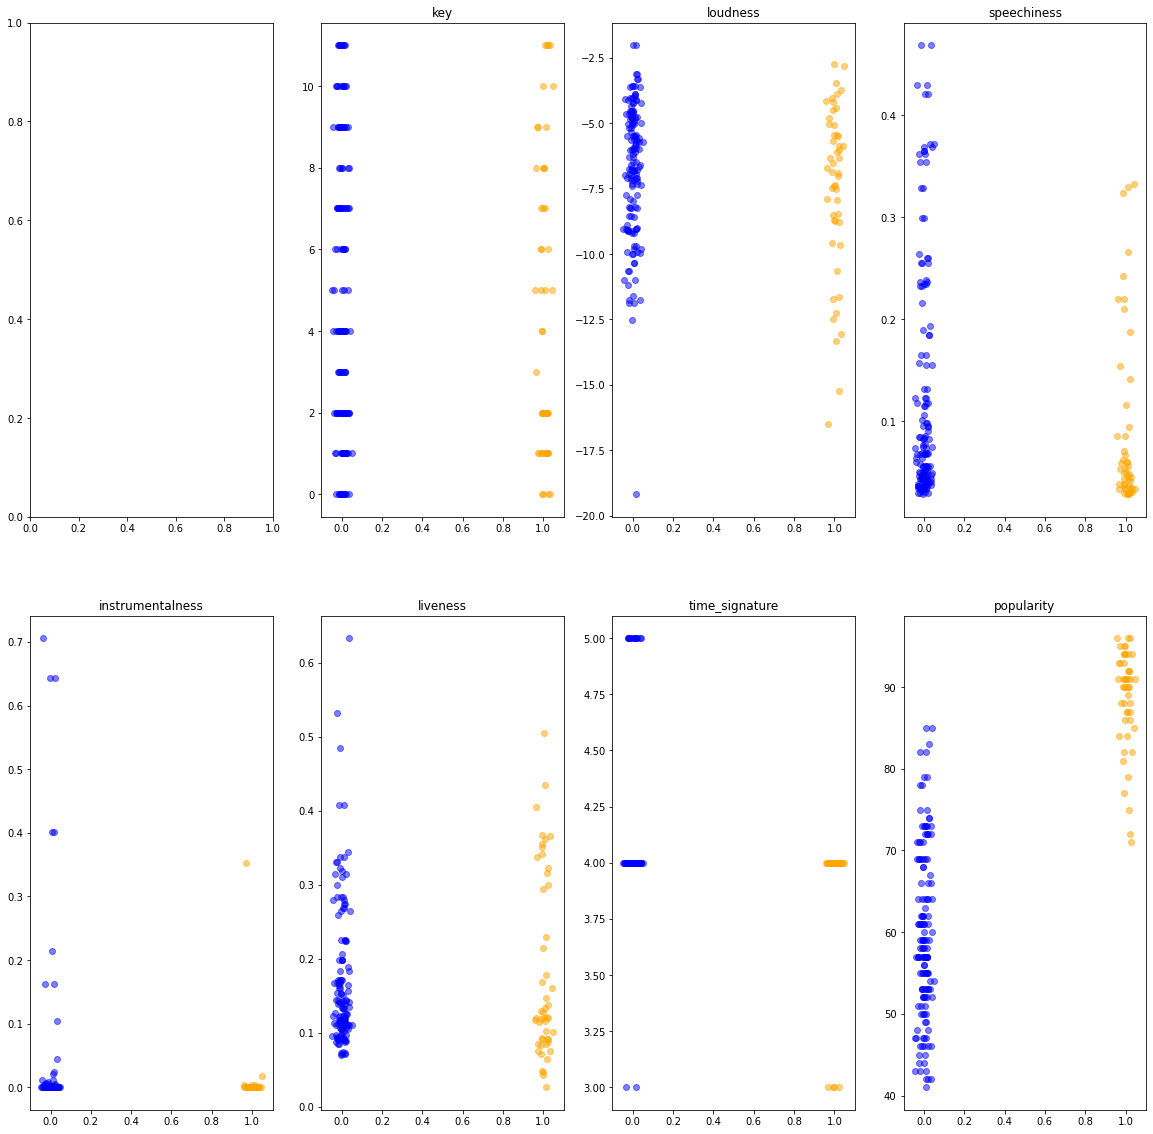

In [63]:
fig5, ax5 = plt.subplots(2, 4, figsize = (20, 20))
                                                                    
ax5[0, 1].title.set_text("key")
ax5[0, 1].scatter(y = trackNamesWithData['key'], x = aJitter, color = 'blue', alpha = .5)
ax5[0, 1].scatter(y = finalDf['key'], x = bJitter, color = 'orange', alpha = .5)                        
                         
ax5[0, 2].title.set_text("loudness")
ax5[0, 2].scatter(y = trackNamesWithData['loudness'], x = aJitter, color = 'blue', alpha = .5)
ax5[0, 2].scatter(y = finalDf['loudness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax5[0, 3].title.set_text("speechiness")
ax5[0, 3].scatter(y = trackNamesWithData['speechiness'], x = aJitter, color = 'blue', alpha = .5)
ax5[0, 3].scatter(y = finalDf['speechiness'], x = bJitter, color = 'orange', alpha = .5)                         
                                                 
ax5[1, 0].title.set_text("instrumentalness")
ax5[1, 0].scatter(y = trackNamesWithData['instrumentalness'], x = aJitter, color = 'blue', alpha = .5)
ax5[1, 0].scatter(y = finalDf['instrumentalness'], x = bJitter, color = 'orange', alpha = .5)                         
                         
ax5[1, 1].title.set_text("liveness")
ax5[1, 1].scatter(y = trackNamesWithData['liveness'], x = aJitter, color = 'blue', alpha = .5)
ax5[1, 1].scatter(y = finalDf['liveness'], x = bJitter, color = 'orange', alpha = .5)                         
                                                 
ax5[1, 2].title.set_text("time_signature")
ax5[1, 2].scatter(y = trackNamesWithData['time_signature'], x = aJitter, color = 'blue', alpha = .5)
ax5[1, 2].scatter(y = finalDf['time_signature'], x = bJitter, color = 'orange', alpha = .5)   

ax5[1, 3].title.set_text("popularity")
ax5[1, 3].scatter(y = trackNamesWithData['popularity'], x = aJitter, color = 'blue', alpha = .5)
ax5[1, 3].scatter(y = finalDf['popularity'], x = bJitter, color = 'orange', alpha = .5)  
                         
plt.show()

I believe key and time_signature look the way they do because their values are integers, and the rest of the values are between 0 and 1. It is interesting how both playlists have songs in every key, and that the New Music Friday playlist has songs in 3 keys, while the Top Songs USA playlist only has the lower 2 keys, not the top key.

As for the rest, it appears that the Top Songs USA playlist has less variability in graphs like popularity and speechiness (popular songs have more words?) and more variability in liveness (popular songs tend to have either very good live music performances or very bad), loudness (some popular songs tend to be very quiet while others tend to be very loud) and instrumentalness (popular songs tend to contain vocals more often than not).

What is most interesting to me is that most of the graphs appear to have a concentration of dots or "tracks" around the same number for both playlists. This means that either new songs are inherently popular, or more and more artists are studying things like this in order to synthesize a song that is guarenteed to hit the charts.

# The Results

This data carries a lot of implications from my point of view. There are probably statistical tests I could perform, but people have already done that to be able to predict what songs will become popular. Now that I've seen the data, I'm more interested in how these songs end up here. Was it by luck? By someone actually looking at data and determining what numbers to get to make a popular song, and making their song around that? What would the perfect "popular" song sound like? Would it actually be popular? These are questions I can't answer by the end of the semester, and I have no idea where I would even start looking for said answers. But this makes me wonder if that's why artists sometimes don't write their own songs. I have heard of people writing lyrics and songs for so many different bands, that sometimes I question if the artist actually wrote the song, or if they're just being used for their voice to carry someone else's opinion. This could lead into politics I'm sure, but I don't think I want to go that route (sorry Dr. Silva :D).

# The Conclusion

Overall, this report was meant to find out if a song I like to listen to has been popular or will become popular in the future. Instead I took a different turn at the last second and asked "why" instead of "when". I think people should take away that music has a lot of underlying information associated with it that may be used for different purposes, or may just be there to make cool websites and to investigate things like this. I also think that this may help recognize why all "pop" genre songs sound the same to some people. They literally have the same characteristics (lots of words, relatively same tempo, the same 2 time signatures in this case) but I would urge people to explore different genres and step out of their comfort zone, listen to other playlists that maybe don't have the "mainstream pop" genre on them, because there's good music everywhere, you just have to find it.